# X(twitter crwaling) - Api

In [ ]:
# 필요한 라이브러리 임포트

from pathlib import Path
import pandas as pd
import requests
import time
import tweepy

In [ ]:
# 트위터 API 인증을 위한 키와 토큰 설정
twitter_consumer_key = "---------------------------"
twitter_consumer_secret = "---------------------------"  
twitter_access_token = "---------------------------"
twitter_access_secret = "---------------------------"
bearer_token = '---------------------------'

## tweet_id로 작성한 user id, screen id 추출

In [ ]:
import requests

def get_user_info_from_tweet(tweet_id, bearer_token):
    headers = {
        'Authorization': f'Bearer {bearer_token}',
    }

    url = f'https://api.twitter.com/2/tweets/{tweet_id}?tweet.fields=author_id,created_at&expansions=author_id&user.fields=username'
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        tweet_info = response.json()
        user_info = tweet_info['includes']['users'][0]
        user_id = user_info['id']
        screen_name = user_info['username']
        return user_id, screen_name
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None, None

# Set tweet ID and bearer token
tweet_id = '1728673116979896589'

user_id, screen_name = get_user_info_from_tweet(tweet_id, bearer_token)
if user_id and screen_name:
    print(f"The user ID of the tweet is: {user_id}")
    print(f"The screen name of the user is: {screen_name}")

## 트윗 id로 부터 리트윗 리스트를 pagination 하면서 반환

In [ ]:
def get_retweeters(tweet_id, bearer_token):
    endpoint = f"https://api.twitter.com/2/tweets/{tweet_id}/retweeted_by"

    headers = {
        "Authorization": f"Bearer {bearer_token}",
    }

    params = {
        "max_results": 100,  # Adjust as needed, maximum is 100 per request
    }

    retweeters = []

    while True:
        response = requests.get(endpoint, headers=headers, params=params)
        
        if response.status_code != 200:
            print(f"Failed to retrieve retweeters. Status code: {response.status_code}")
            if response.status_code == 429:
                print("Rate limit exceeded. Waiting for 15 minutes...")
                time.sleep(15 * 60)  # Wait for 15 minutes
                continue
            break

        remaining_limit = int(response.headers.get('x-rate-limit-remaining', 0))
        reset_time = int(response.headers.get('x-rate-limit-reset', 0))

        if remaining_limit == 0:
            wait_time = max(0, reset_time - int(time.time())) + 5  # Add 5 seconds buffer
            print(f"Rate limit exceeded. Waiting for {wait_time} seconds...")
            time.sleep(wait_time)
            continue

        retweeters_data = response.json()
        retweeters.extend(retweeters_data.get("data", []))

        if "meta" in retweeters_data and "next_token" in retweeters_data["meta"]:
            pagination_token = retweeters_data["meta"]["next_token"]
            params["pagination_token"] = pagination_token
        else:
            break

    return retweeters

def save_to_csv(user_ids, outputfile_name = 'retweeters.csv'):
    import csv
    csv_filename = outputfile_name
    csv_columns = ['user_id']

    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for user_id in user_ids:
            writer.writerow({'user_id': user_id})

    print(f"Retweeters' IDs saved to {csv_filename}")

In [ ]:
import csv
# Replace 'YOUR_BEARER_TOKEN' with your actual Twitter API v2 bearer token
bearer_token = '----------------------------'

# Replace 'YOUR_TWEET_ID' with the ID of the tweet you want to retrieve retweeters for
tweet_id = '1728673116979896589'

retweeters = get_retweeters(tweet_id, bearer_token)
print(f"Retweeters: {len(retweeters)}")
print(retweeters)
save_to_csv(retweeters)

## 키워드에 따라 retweet된 트윗을 검색

In [ ]:
import tweepy

bearer_token = 'AAAAAAAAAAAAAAAAAAAAADLPrAEAAAAANN1XYX8%2BR%2Fqkk3AZ%2FSnTKFn%2BsKI%3Dykfm5SLshMxMzrQycLit7S4cPeyODu9yDNi7ZLQGUG0kWWIMIB'
client = tweepy.Client(bearer_token,wait_on_rate_limit=True)

def get_tweets_by_keyword(keyword, max_results=10):
    tweets = client.search_recent_tweets(query=keyword, max_results=max_results, expansions=['author_id','referenced_tweets.id'],until_id=1732407860288754144)#퀴어 1000개 마지막:1732076931733229753 입시 400개 마지막 1732630378375225404 남성혐오 400개 마지막 1733035092560449933
    return tweets.data

# 키워드와 최대 결과 수를 지정하여 트윗 가져오기
search_term = "손가락논란 is:retweet"  #리트윗이 있는 트윗들만 추출
max_results = 100  
searched_tweets = get_tweets_by_keyword(search_term, max_results)

## 검색된 트윗으로부터 {원본 user : retweet한 user}형태의 딕셔너리 생성

In [ ]:
referenced_tweets_list=[]
for i in range(max_results):# 리트윗된 원본 트윗 출력
    referenced_tweets_list.append(searched_tweets[i].referenced_tweets)
print(referenced_tweets_list)

id_list = []
for tweet in referenced_tweets_list:
    if tweet:  # 'referenced_tweets'가 None이 아닌 경우에만 'id' 정보 추출
        id_list.append(tweet[0].id)

#api의 효율적 사용을 위한 중복 제거
id_set = list(set(id_list))

# 원본트윗의 user_id만 추출
original_tweet_info_list=[]
for i in id_set:
    original_tweet_info_list.append(client.get_tweet(id=i, expansions=['author_id']))


original_user_ids=[]
for i in range(len(id_set)):
    original_user_ids.append(original_tweet_info_list[i].includes['users'][0].id)


#원본트윗을 리트윗한 사용자들의 user_id만 추출
tmp = []
for i in id_set:
    retweeters_responses = client.get_retweeters(id=i) #리트윗한 사용자 목록
    print(retweeters_responses)
    retweeterss = [user.id for user in retweeters_responses.data] #리트윗한 사용자 목록의 id만 저장
    tmp.append(retweeterss)

result = dict(zip(original_user_ids, tmp))

In [ ]:
import csv

data = result

# 노드 및 엣지 정보 CSV 파일로 저장
with open('손가락논란_graph_data3.csv', 'w', newline='') as csvfile:
    fieldnames = ['source', 'target']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for source, targets in data.items():
        for target in targets:
            writer.writerow({'source': source, 'target': target})

## 기타 전처리 코드

In [ ]:
# 데이터프레임들을 리스트에 담기
dataframes = ['data1, data2, data3, data4 .... ']

# 데이터프레임들 합치기 (concat)
combined_df = pd.concat(dataframes, ignore_index=True)


combined_df.to_csv('output.csv', index=False)

# 중복 행 제거
combined_df.drop_duplicates(subset=['source', 'target'], keep='first', inplace=True)

import pandas as pd

# CSV 파일 불러오기
data = pd.read_csv("retweeters.csv")

# 'user_id' 열의 JSON 데이터 파싱하여 'id' 값 추출 후 새로운 열 생성
data['id'] = data['user_id'].apply(lambda x: eval(x)['id'])

#딕셔너리 생성
dict = {'1098531747547860992':list(data['id'])}


# graph analyzing

## function

In [113]:
import pandas as pd 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def analyze_network(G):
    metrics = {}

    # Basic info
    metrics['number_of_nodes'] = G.number_of_nodes()
    metrics['number_of_edges'] = G.number_of_edges()

    # Density for directed graphs
    metrics['density'] = nx.density(G)

    # Centrality measures
    metrics['degree_centrality'] = nx.degree_centrality(G)
    metrics['betweenness_centrality'] = nx.betweenness_centrality(G)
    metrics['closeness_centrality'] = nx.closeness_centrality(G)

    # Clustering
    metrics['average_clustering'] = nx.average_clustering(G)
    metrics['clustering_coefficient'] = nx.clustering(G)

    # Path-based metrics
    if nx.is_weakly_connected(G):
        # Use the largest weakly connected component for path-based metrics
        largest_wcc = max(nx.weakly_connected_components(G), key=len)
        subgraph = G.subgraph(largest_wcc)
        metrics['average_path_length'] = nx.average_shortest_path_length(subgraph)
        metrics['diameter'] = nx.diameter(subgraph.to_undirected())
    else:
        metrics['average_path_length'] = None
        metrics['diameter'] = None

    # Modularity and community detection are not included here as they require
    # additional packages and steps to implement.

    return metrics




def analyze_and_plot_network(G):
    # Compute PageRank
    page_ranks = nx.pagerank(G, alpha=0.85)

    # Identifying 'Speakers'
    speakers = {node: rank for node, rank in sorted(page_ranks.items(), key=lambda item: item[1], reverse=True)}

    # Identifying 'Audience'
    audience_influence = {}
    for node in G.nodes():
        in_edges = G.in_edges(node)  # Gets edges directed towards 'node'
        audience_influence[node] = sum(page_ranks[source] for source, _ in in_edges)

    # Sorting 'Audience' by influence score in descending order
    sorted_audience = sorted(audience_influence.items(), key=lambda item: item[1], reverse=True)

    # Plotting
    plt.figure(figsize=(12, 6))

    # PageRank Distribution
    plt.subplot(1, 2, 1)
    plt.hist(list(page_ranks.values()), bins=30, color='blue', alpha=0.7)
    plt.title('Distribution of PageRank Values')
    plt.xlabel('PageRank')
    plt.ylabel('Frequency')

    # Audience Influence Distribution
    plt.subplot(1, 2, 2)
    plt.hist([score for _, score in sorted_audience], bins=30, color='green', alpha=0.7)
    plt.title('Distribution of Audience Influence Scores')
    plt.xlabel('Audience Influence Score')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return speakers, sorted_audience

def remove_low_interaction_nodes(G):
    nodes_to_remove = [node for node in G.nodes() if G.degree(node) == 1 and G.in_degree(node) == 1]
    G.remove_nodes_from(nodes_to_remove)
    return G

def compare_networks(original_graph, preprocessed_graph):
    # Calculate metrics for the original network
    original_metrics = {
        'number_of_nodes': original_graph.number_of_nodes(),
        'number_of_edges': original_graph.number_of_edges(),
        'density': nx.density(original_graph),
        'average_clustering': nx.average_clustering(original_graph),
        'average_shortest_path_length': nx.average_shortest_path_length(original_graph) if nx.is_connected(original_graph.to_undirected()) else None
    }

    # Calculate metrics for the preprocessed network
    preprocessed_metrics = {
        'number_of_nodes': preprocessed_graph.number_of_nodes(),
        'number_of_edges': preprocessed_graph.number_of_edges(),
        'density': nx.density(preprocessed_graph),
        'average_clustering': nx.average_clustering(preprocessed_graph),
        'average_shortest_path_length': nx.average_shortest_path_length(preprocessed_graph) if nx.is_connected(preprocessed_graph.to_undirected()) else None
    }

    # Calculate the remaining rate
    remaining_rate = {}
    for key in original_metrics:
        if original_metrics[key] is not None and original_metrics[key] != 0:
            if preprocessed_metrics[key] is not None:
                remaining_rate[key] = preprocessed_metrics[key] / original_metrics[key]
            else:
                remaining_rate[key] = None
        else:
            remaining_rate[key] = None

    return original_metrics, preprocessed_metrics, remaining_rate


In [43]:
# 데이터 불러오기
gender = pd.read_csv("gender_issue_graph_data.csv")
science = pd.read_csv("science_graph_data_600.csv")
queer = pd.read_csv("퀴어_graph_data1&2&3&4&5&6&7&8&9&10.csv")
sat = pd.read_csv("입시&등급컷_graph_data4&2.csv")

## 과학

{7.446684101816238e+17: 0.0004712724081190673, 314606842: 0.0004903085566824358, 734537086318088196: 0.0004903085566824358, 112721329: 0.0004903085566824358, 215902890: 0.0004903085566824358, 2388794802: 0.0004903085566824358, 3096252824: 0.0004903085566824358, 724087287634501632: 0.0004903085566824358, 49445647: 0.0004903085566824358, 2377011859: 0.0004903085566824358, 18961853: 0.0004903085566824358, 2594906006: 0.0004903085566824358, 221201072: 0.0004903085566824358, 523091724: 0.0004903085566824358, 371269347: 0.0004903085566824358, 815050: 0.0004903085566824358, 113826929: 0.0005045856681049623, 4197710365: 0.0004903085566824358, 423024936: 0.0004903085566824358, 63642508: 0.0004903085566824358, 384157921: 0.0004903085566824358, 2501440866: 0.0004903085566824358, 1.2078578701227827e+18: 0.0004712724081190673, 1568885577696817153: 0.00048554951954159366, 748449720876425217: 0.00048554951954159366, 981141214530437120: 0.00048554951954159366, 1128260593285156872: 0.000485549519541593

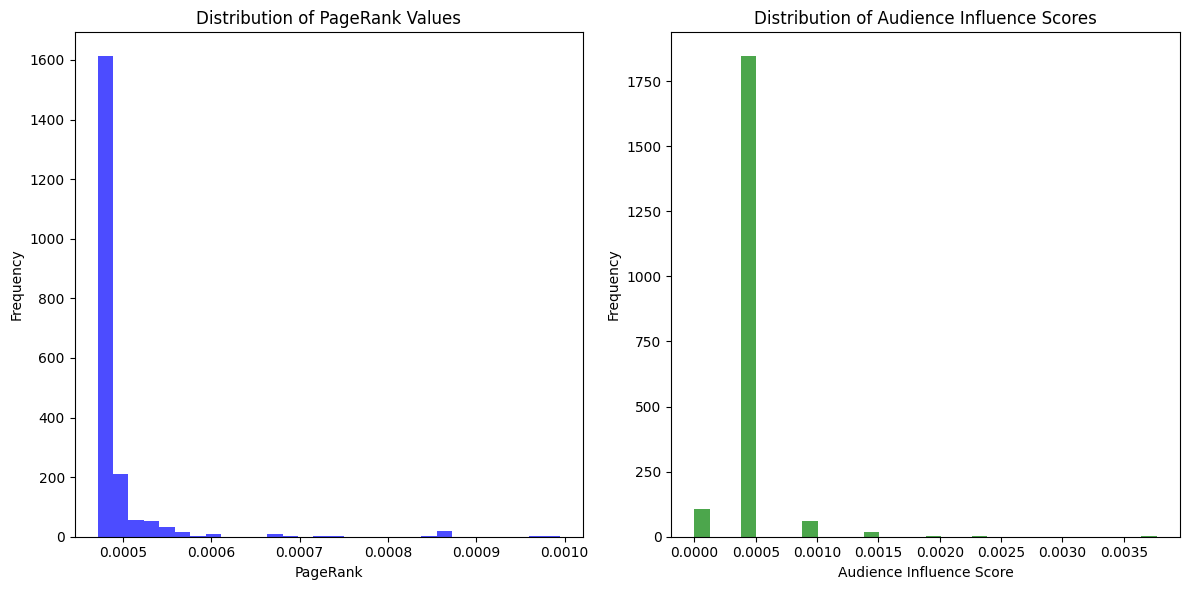

({1672950716229652480: 0.0009949128256419525,
  783754268478021632: 0.000984296611901849,
  1053884703063781379: 0.0009709713079074912,
  1657774575428726784: 0.0008710315279498064,
  1342695383902744579: 0.0008710315279498064,
  1475150198695690241: 0.0008710315279498064,
  1663879038623191041: 0.0008710315279498064,
  2503594524: 0.0008710315279498064,
  978241484637065217: 0.0008710315279498064,
  1706927086236217344: 0.0008710315279498064,
  1258091635197394945: 0.0008710315279498064,
  846343029074018305: 0.0008710315279498064,
  1637407331775545346: 0.0008710315279498064,
  847523847100170240: 0.0008710315279498064,
  1590661519368671238: 0.0008710315279498064,
  1620142239585570816: 0.0008710315279498064,
  1626011662213083136: 0.0008710315279498064,
  95145482: 0.0008710315279498064,
  1556907766450642944: 0.0008710315279498064,
  1679878997466050560: 0.0008710315279498064,
  4151157729: 0.0008710315279498064,
  1661253775024353280: 0.0008615134536681221,
  774764836647424000: 

In [114]:
node = science
# 그래프 생성
G = nx.from_pandas_edgelist(node, 'Key', 'Value',create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))
pr = nx.pagerank(G,alpha=0.85)
print(pr)

# 노드 리스트 추출
nodes = list(G.nodes())

# 노드 개수를 기반으로 빈 행렬 생성
adj_matrix = np.zeros((len(nodes), len(nodes)))

# 각 엣지에 대한 인접 행렬 정보 채우기
for edge in G.edges():
    source_idx = nodes.index(edge[0])
    target_idx = nodes.index(edge[1])
    adj_matrix[source_idx][target_idx] = 1

# 그래프 생성
G = nx.from_pandas_edgelist(node, 'Key', 'Value',create_using=nx.DiGraph)
pr = nx.pagerank(G,alpha=0.85)

network_metrics = analyze_network(G)
print(network_metrics)
analyze_and_plot_network(G)

{7.446684101816238e+17: 0.004262499468277713, 113826929: 0.009697658381636656, 1.2078578701227827e+18: 0.004262499468277713, 750351312324218880: 0.007885938743850343, 1.608943029460816e+18: 0.004262499468277713, 1.6620490351744328e+18: 0.004262499468277713, 970173631476129795: 0.0069800789249571836, 1083504996266663936: 0.0069800789249571836, 1.727341720449512e+18: 0.004262499468277713, 1470020721292505088: 0.007885938743850343, 1366274130186706951: 0.006954197215845951, 1.6124594425699e+18: 0.004262499468277713, 1.2605847575843717e+18: 0.004262499468277713, 3059833170: 0.006678125651992798, 808643960214126592: 0.006678125651992798, 1.6936218325516782e+18: 0.004262499468277713, 244004018: 0.0069800789249571836, 1471691317810200579: 0.0069800789249571836, 1.6854995094918676e+18: 0.004262499468277713, 1672950716229652480: 0.015132817294995599, 1085446381: 0.006376172379028412, 1360153606888935425: 0.0069800789249571836, 1548674292527013888: 0.006074219106064027, 1.6575455071312527e+18: 0

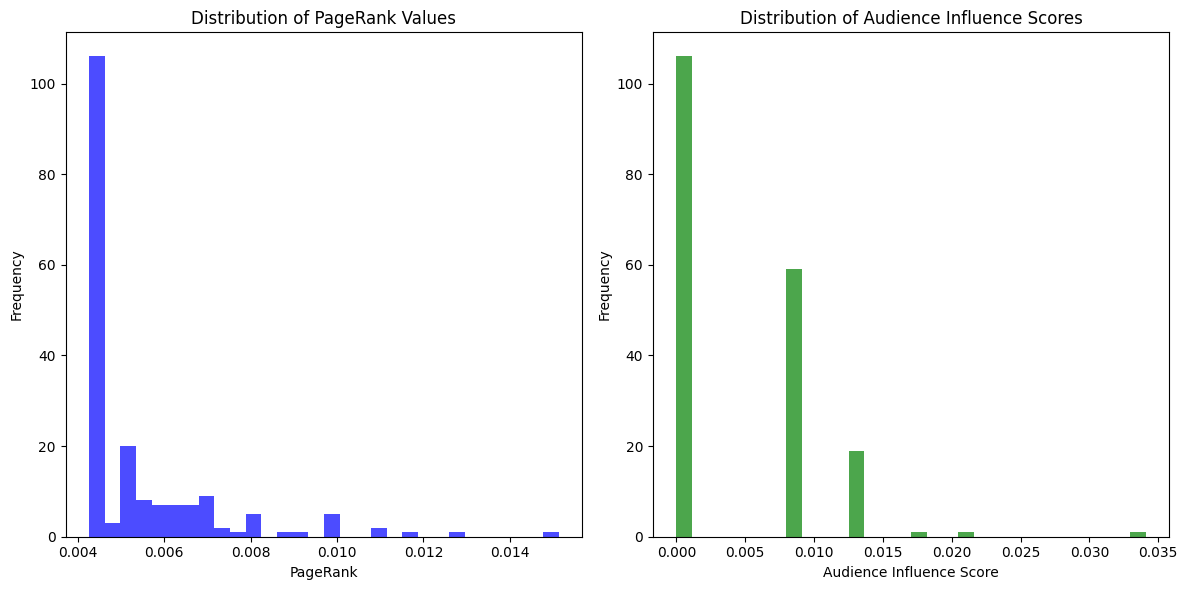

({1672950716229652480: 0.015132817294995599,
  1661253775024353280: 0.012717191111280512,
  1053884703063781379: 0.01150937801942297,
  1127934478272217089: 0.010905471473494199,
  783754268478021632: 0.010905471473494199,
  113826929: 0.009697658381636656,
  966318521213861888: 0.009697658381636656,
  73102097: 0.009697658381636656,
  1707578926208622592: 0.009697658381636656,
  1640912733318311936: 0.009697658381636656,
  774764836647424000: 0.009093751835707884,
  1500620005054238720: 0.0087917985627435,
  1070516237287845888: 0.008248282671407604,
  194860208: 0.008164664841971314,
  750351312324218880: 0.007885938743850343,
  1470020721292505088: 0.007885938743850343,
  2189908434: 0.007885938743850343,
  925541674889052160: 0.007860057034739108,
  978431095145357312: 0.00728203219792157,
  1661674674571595777: 0.00728203219792157,
  970173631476129795: 0.0069800789249571836,
  1083504996266663936: 0.0069800789249571836,
  244004018: 0.0069800789249571836,
  1471691317810200579: 0

In [106]:
node = science
# 그래프 생성
G = nx.from_pandas_edgelist(node, 'Key', 'Value',create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))
G_preprocessed = remove_low_interaction_nodes(G)
pr = nx.pagerank(G_preprocessed,alpha=0.85)
print(pr)

# 노드 리스트 추출
nodes = list(G_preprocessed.nodes())

# 노드 개수를 기반으로 빈 행렬 생성
adj_matrix = np.zeros((len(nodes), len(nodes)))

# 각 엣지에 대한 인접 행렬 정보 채우기
for edge in G_preprocessed.edges():
    source_idx = nodes.index(edge[0])
    target_idx = nodes.index(edge[1])
    adj_matrix[source_idx][target_idx] = 1


network_metrics = analyze_network(G_preprocessed)
print(network_metrics)
analyze_and_plot_network(G_preprocessed)

In [107]:
G.remove_edges_from(nx.selfloop_edges(G))
page_ranks = nx.pagerank(G, alpha=0.85)
audience_influence = {}
for node in G.nodes():
    in_edges = G.in_edges(node)
    audience_influence[node] = sum(page_ranks[source] for source, _ in in_edges)

# Add PageRank and audience influence as attributes to each node
for node in G.nodes():
    G.nodes[node]['pagerank'] = page_ranks[node]
    G.nodes[node]['audience_influence'] = audience_influence[node]

# Export the network to a GEXF file
nx.write_gexf(G, "network.gexf")

In [116]:
G = nx.from_pandas_edgelist(node, 'Key', 'Value',create_using=nx.DiGraph)
original_metrics, preprocessed_metrics, changerate = compare_networks(G, G_preprocessed)
print(original_metrics)
print(preprocessed_metrics)
print(changerate)

{'number_of_nodes': 2032, 'number_of_edges': 2037, 'density': 0.0004935798276323288, 'average_clustering': 0.0, 'average_shortest_path_length': None}
{'number_of_nodes': 172, 'number_of_edges': 154, 'density': 0.005235958112335101, 'average_clustering': 0.0, 'average_shortest_path_length': None}
{'number_of_nodes': 0.08464566929133858, 'number_of_edges': 0.07560137457044673, 'density': 10.608128248376074, 'average_clustering': None, 'average_shortest_path_length': None}


## gender_issue

{1113520711992107008: 0.00021972007758353055, 2520572712: 0.00021972007758353055, 1956247369: 0.00021972007758353055, 1566172488442478592: 0.00021972007758353055, 1217407559042129921: 0.00021972007758353055, 712920158340325376: 0.00021972007758353055, 1491273373829062658: 0.00021972007758353055, 1183316483004174341: 0.00021972007758353055, 1029436352834617344: 0.00021972007758353055, 1133561777055076352: 0.00021972007758353055, 1115660094870437888: 0.00021972007758353055, 1247942853830930432: 0.00021972007758353055, 1565680537435484160: 0.00022370791394074022, 1059744667661565953: 0.00021972007758353055, 1522929604973023235: 0.00021972007758353055, 1567242654571954176: 0.00021972007758353055, 1455829679957446657: 0.00021972007758353055, 4610531112: 0.00021972007758353055, 1562075793236250627: 0.00021972007758353055, 4097984958: 0.00021972007758353055, 1505184079322308608: 0.00021972007758353055, 1118006161209303040: 0.00021972007758353055, 1115191685946822656: 0.00021972007758353055, 1

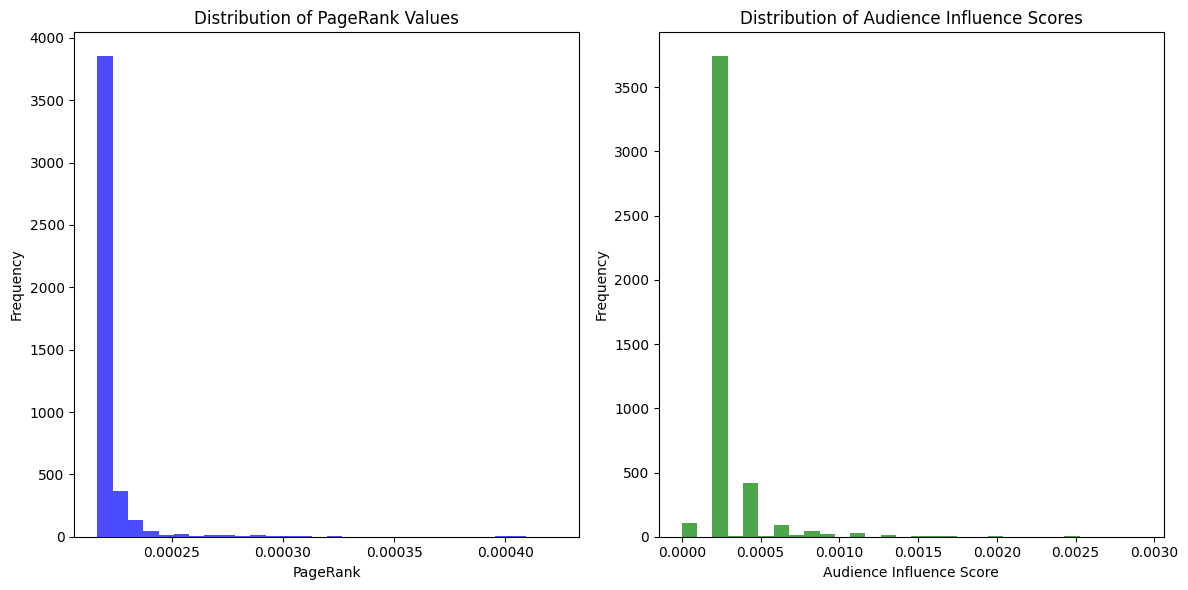

({1644605359053758467: 0.00042293870071540983,
  846169302667411456: 0.00041526125170432464,
  1685524869776396288: 0.00040532210180492154,
  326612299: 0.00040456422625823345,
  94312053: 0.0004005763899010238,
  1134675372014854144: 0.0004005763899010238,
  1579024632: 0.0004005763899010238,
  1728748181729734656: 0.0004005763899010238,
  794472708452950016: 0.0004005763899010238,
  1457410915473956864: 0.0004005763899010238,
  1668917319459033089: 0.00038388754620531364,
  843283120434679808: 0.00035303754930239215,
  926614641840553985: 0.0003246393166789838,
  756678985392586753: 0.00032183854359210136,
  1015701504311767040: 0.0003199352645293409,
  1170706402337116160: 0.0003167359655084927,
  4518681672: 0.00030856573067786577,
  1494874529063079936: 0.00030856573067786577,
  1287686087666622465: 0.00030856573067786577,
  1639932374288052224: 0.00030856573067786577,
  1732275670754230272: 0.00030856573067786577,
  1319462612686389248: 0.00030465514748168065,
  15666600585824952

In [77]:
node = gender
# 그래프 생성
G = nx.from_pandas_edgelist(node, 'source', 'target',create_using=nx.DiGraph)
pr = nx.pagerank(G,alpha=0.85)
print(pr)

# 노드 리스트 추출
nodes = list(G.nodes())

# 노드 개수를 기반으로 빈 행렬 생성
adj_matrix = np.zeros((len(nodes), len(nodes)))

# 각 엣지에 대한 인접 행렬 정보 채우기
for edge in G.edges():
    source_idx = nodes.index(edge[0])
    target_idx = nodes.index(edge[1])
    adj_matrix[source_idx][target_idx] = 1

network_metrics = analyze_network(G)
print(network_metrics)
analyze_and_plot_network(G)

{1113520711992107008: 0.001455219994996435, 1565680537435484160: 0.0015088991870711296, 1459124764149428225: 0.0014651611199782688, 807555014306603008: 0.0014995031880973306, 1462991516721238020: 0.0012624544026301264, 1559770462032240640: 0.0012610143452492749, 1725881641435078657: 0.0014332695485576859, 1295555663314051075: 0.0012373488331467722, 1604402736908599296: 0.0012266664839338368, 899212454969753600: 0.0012588977442761868, 975391968342687744: 0.0013543439656669605, 1395472656124694528: 0.001408107087002347, 1239796949387100162: 0.001267259410942991, 1149724482: 0.001244384199038543, 4825586827: 0.0011960146819065163, 142579779: 0.0013236402589707253, 1256106812543123456: 0.001230356750025578, 2233298252: 0.001232465473506573, 1383706245152968708: 0.0012746399431264736, 762524456547868673: 0.0012524983465760258, 1218740754: 0.0012719821839703087, 737611760794886149: 0.0017343276444393714, 1647533652031705088: 0.001213908706873817, 95900144: 0.0013452474284452916, 958404274987

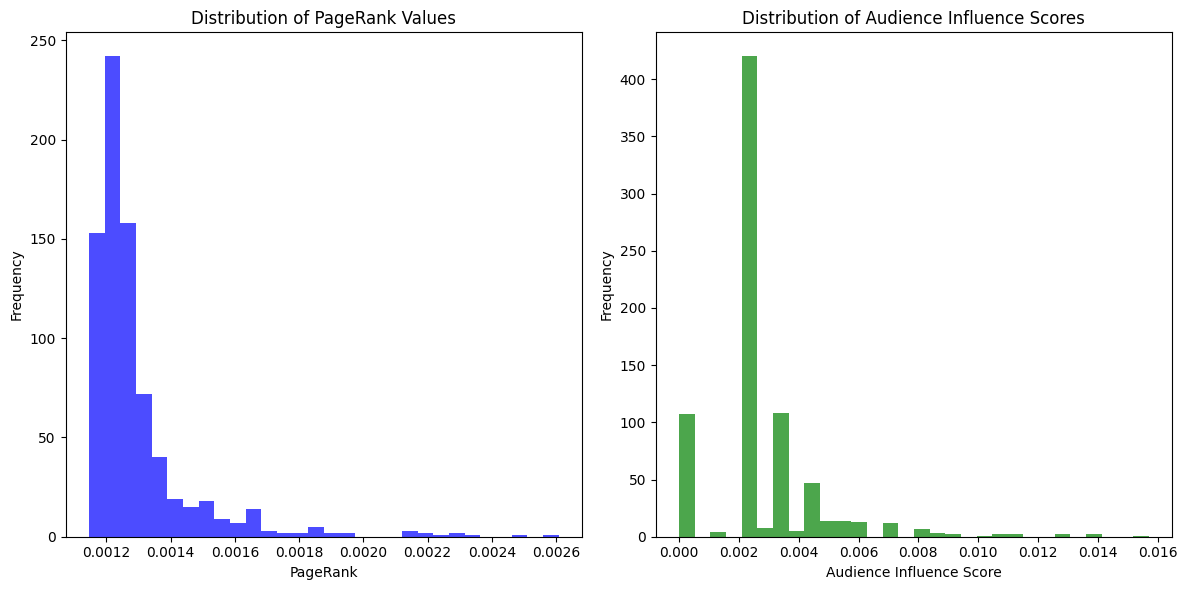

({1235106097175773186: 0.002607678789945691,
  1296357335883894785: 0.0025057141346188565,
  846169302667411456: 0.002361870997965651,
  1644605359053758467: 0.0023098450484059082,
  1685524869776396288: 0.002306613668011217,
  926614641840553985: 0.002253264716732363,
  1015701504311767040: 0.0021991294934460962,
  326612299: 0.0021742428579105346,
  1668917319459033089: 0.0021589475251643873,
  1503048625437683712: 0.002155357603272258,
  1140003547: 0.0021462013039468854,
  1170706402337116160: 0.00192881126907603,
  843283120434679808: 0.0019282813800030048,
  1250995007315562498: 0.0019212892968818107,
  1715665512053743616: 0.0019169461543743853,
  1319462612686389248: 0.001876986681327801,
  1088574262678450176: 0.001874732576119001,
  756678985392586753: 0.001868098649529719,
  1502198890728099844: 0.001853932229480975,
  60690714: 0.001832379097068988,
  1218816734246903809: 0.0018202595873372278,
  1642834399745175552: 0.0017912013453374293,
  1521000126458007553: 0.001741696

In [121]:
node = gender
# 그래프 생성
G = nx.from_pandas_edgelist(node, 'source', 'target',create_using=nx.DiGraph)
G_preprocessed = remove_low_interaction_nodes(G)
pr = nx.pagerank(G_preprocessed,alpha=0.85)
print(pr)

# 노드 리스트 추출
nodes = list(G_preprocessed.nodes())

# 노드 개수를 기반으로 빈 행렬 생성
adj_matrix = np.zeros((len(nodes), len(nodes)))

# 각 엣지에 대한 인접 행렬 정보 채우기
for edge in G_preprocessed.edges():
    source_idx = nodes.index(edge[0])
    target_idx = nodes.index(edge[1])
    adj_matrix[source_idx][target_idx] = 1

network_metrics = analyze_network(G_preprocessed)
print(network_metrics)
analyze_and_plot_network(G_preprocessed)

In [122]:
node = gender
G = nx.from_pandas_edgelist(node, 'source', 'target',create_using=nx.DiGraph)
original_metrics, preprocessed_metrics, changerate = compare_networks(G, G_preprocessed)
print(original_metrics)
print(preprocessed_metrics)
print(changerate)

{'number_of_nodes': 4512, 'number_of_edges': 5576, 'density': 0.0002739560192500287, 'average_clustering': 0.001713743328017252, 'average_shortest_path_length': None}
{'number_of_nodes': 774, 'number_of_edges': 1838, 'density': 0.0030720271702250703, 'average_clustering': 0.01035374573857751, 'average_shortest_path_length': None}
{'number_of_nodes': 0.17154255319148937, 'number_of_edges': 0.32962697274031566, 'density': 11.213577926248643, 'average_clustering': 6.041596526917758, 'average_shortest_path_length': None}


## queer

{1130008146565402624: 0.0009612906695643878, 3313375814: 0.0009783072304407725, 1555219567231700992: 0.0009783072304407725, 1711306491322654720: 0.0009783072304407725, 1670324593893203968: 0.0009783072304407725, 828258118987509760: 0.0009783072304407725, 2959239024: 0.0009783072304407725, 1063879319355715584: 0.0009783072304407725, 1337414281168441346: 0.0009783072304407725, 770706214493696000: 0.0009783072304407725, 1055844508020072449: 0.0009783072304407725, 960428437486821376: 0.0009783072304407725, 1345039735899582464: 0.0009783072304407725, 1280142752978632705: 0.0009783072304407725, 812663253604048896: 0.0009783072304407725, 721647068167557120: 0.0009783072304407725, 1171776225716494336: 0.0009783072304407725, 924469436773425153: 0.0009783072304407725, 866702655229378561: 0.0009783072304407725, 1020628063120371714: 0.0009783072304407725, 1087928919934816256: 0.0009783072304407725, 4385346979: 0.0009783072304407725, 2591491088: 0.0009783072304407725, 1076862788130074625: 0.0009783

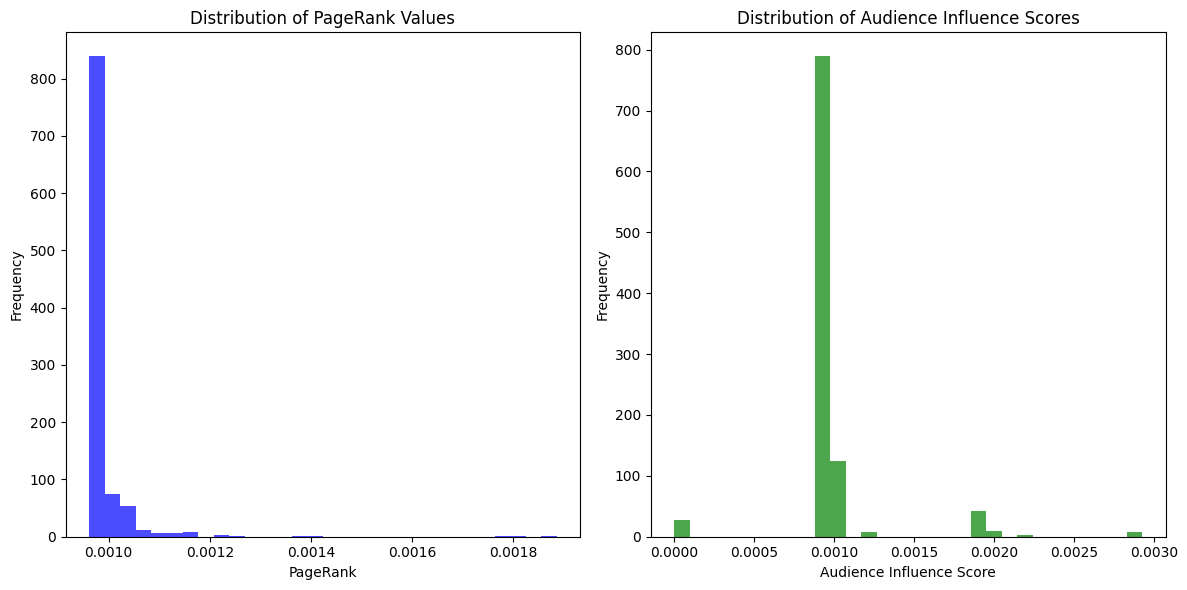

({1558585593780903936: 0.001886167624114732,
  1514514883496538112: 0.0018157354092441925,
  1668661658468900865: 0.0017780855916308524,
  1629224048327811072: 0.0017780855916308524,
  1334085321860935680: 0.0014207378132267742,
  1399561310791102465: 0.00136968813059762,
  719467646295539712: 0.0012531877649213964,
  2468093228: 0.0012101985584968456,
  1681711268078702593: 0.0012101985584968456,
  2543393280: 0.0012101985584968456,
  1707412934731931648: 0.001165489400081004,
  1198898283013271552: 0.001165489400081004,
  1544602433560936448: 0.001165489400081004,
  1667101604972208128: 0.001165489400081004,
  1597944531122806786: 0.001165489400081004,
  967747918064058371: 0.001165489400081004,
  1052067239577284609: 0.001165489400081004,
  1515359400902332417: 0.001165489400081004,
  1555059933418487808: 0.0011246496539776807,
  1686611960379715584: 0.0011246496539776807,
  1434788766946762755: 0.0011246496539776807,
  1613939302244974592: 0.0011246496539776807,
  15646160302566563

In [123]:
node = queer
# 그래프 생성
G = nx.from_pandas_edgelist(node, 'source', 'target',create_using=nx.DiGraph)
pr = nx.pagerank(G,alpha=0.85)
print(pr)

# 노드 리스트 추출
nodes = list(G.nodes())

# 노드 개수를 기반으로 빈 행렬 생성
adj_matrix = np.zeros((len(nodes), len(nodes)))

# 각 엣지에 대한 인접 행렬 정보 채우기
for edge in G.edges():
    source_idx = nodes.index(edge[0])
    target_idx = nodes.index(edge[1])
    adj_matrix[source_idx][target_idx] = 1

network_metrics = analyze_network(G)
print(network_metrics)
analyze_and_plot_network(G)

{1130008146565402624: 0.008405447858181148, 792952185617195009: 0.008405447858181148, 1495290392140402690: 0.010070679389383521, 925541674889052160: 0.009475271557003322, 2542714939: 0.010213106738037464, 746339484426371075: 0.008405447858181148, 815472156: 0.009674606658781044, 760899001918992384: 0.009972310574971143, 2468093228: 0.01172851445687905, 1583097765743427585: 0.013810335637908145, 1291008442090401792: 0.008405447858181148, 4494585432: 0.009972310574971143, 935561229963214849: 0.008405447858181148, 1708938706802147328: 0.011207367069382081, 2990012036: 0.01217445018587812, 1588128014319046656: 0.008405447858181148, 1153199034338725888: 0.008405447858181148, 1493159745393676288: 0.008405447858181148, 194681994: 0.008405447858181148, 1121778846691282944: 0.009972310574971143, 2877379356: 0.011382487020082141, 1666650206363078657: 0.009972310574971143, 2233298252: 0.010191671355321744, 553730277: 0.014983431688451674, 1397108413826359297: 0.009201782791890887, 949363622756560

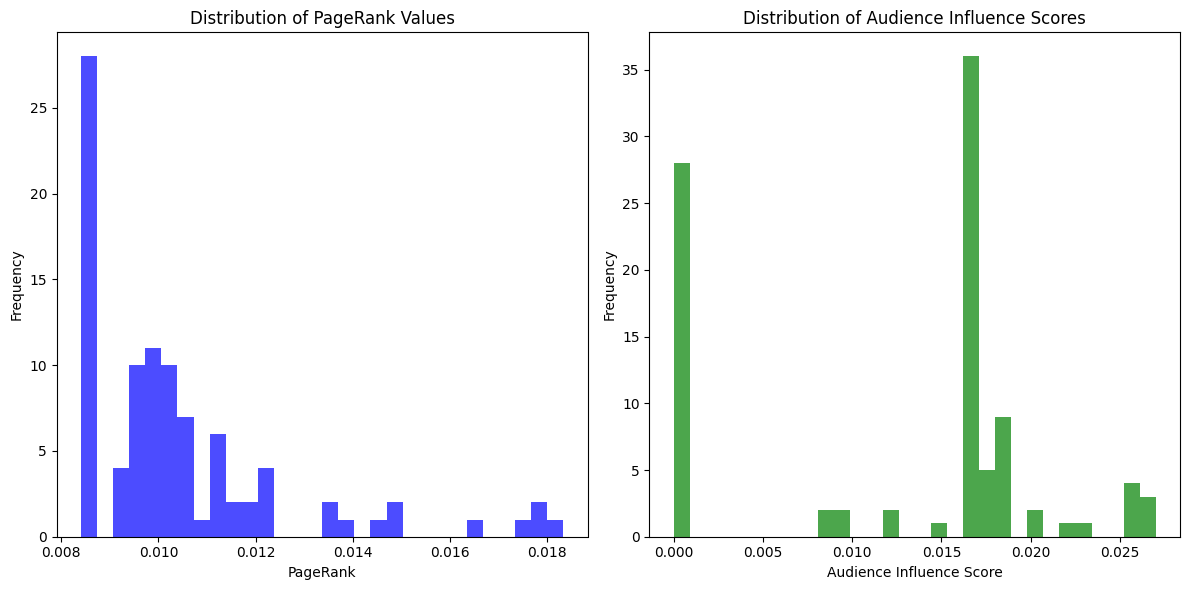

({1558585593780903936: 0.018335856626589646,
  1501062236009558018: 0.01793197317626433,
  1334085321860935680: 0.017931973176264326,
  1454447399364038658: 0.017414494800515906,
  1255019698317484032: 0.01654963312944905,
  553730277: 0.014983431688451674,
  1221749960917471234: 0.014833912828320233,
  1322392182012014592: 0.014607384636422076,
  1583097765743427585: 0.013810335637908145,
  1510776211546734592: 0.013588998398902877,
  719467646295539712: 0.013514737954019649,
  1675652197244338177: 0.012230944259794171,
  382023067: 0.012216057985414419,
  964921696091176960: 0.012206658352087596,
  2990012036: 0.01217445018587812,
  2468093228: 0.01172851445687905,
  1681711268078702593: 0.01172851445687905,
  1485678604130263042: 0.011635536427413972,
  1088430031607496706: 0.01162065015303422,
  2877379356: 0.011382487020082141,
  4127146274: 0.011382487020082141,
  2853568100: 0.0112217976540698,
  1708938706802147328: 0.011207367069382081,
  830367532276019200: 0.0111909626380272

In [124]:
node = queer
# 그래프 생성
G = nx.from_pandas_edgelist(node, 'source', 'target',create_using=nx.DiGraph)
G_preprocessed = remove_low_interaction_nodes(G)
pr = nx.pagerank(G_preprocessed,alpha=0.85)
print(pr)

# 노드 리스트 추출
nodes = list(G_preprocessed.nodes())

# 노드 개수를 기반으로 빈 행렬 생성
adj_matrix = np.zeros((len(nodes), len(nodes)))

# 각 엣지에 대한 인접 행렬 정보 채우기
for edge in G_preprocessed.edges():
    source_idx = nodes.index(edge[0])
    target_idx = nodes.index(edge[1])
    adj_matrix[source_idx][target_idx] = 1


network_metrics = analyze_network(G_preprocessed)
print(network_metrics)
analyze_and_plot_network(G_preprocessed)

In [125]:
G = nx.from_pandas_edgelist(node, 'source', 'target',create_using=nx.DiGraph)
original_metrics, preprocessed_metrics, changerate = compare_networks(G, G_preprocessed)
print(original_metrics)
print(preprocessed_metrics)
print(changerate)

{'number_of_nodes': 1010, 'number_of_edges': 1050, 'density': 0.0010303309815619817, 'average_clustering': 0.0004984445813002352, 'average_shortest_path_length': None}
{'number_of_nodes': 96, 'number_of_edges': 136, 'density': 0.014912280701754385, 'average_clustering': 0.006324404761904763, 'average_shortest_path_length': None}
{'number_of_nodes': 0.09504950495049505, 'number_of_edges': 0.1295238095238095, 'density': 14.47329156223893, 'average_clustering': 12.688280701952891, 'average_shortest_path_length': None}


## 수능

{1632412963025076224: 0.0004501916836610853, 1559857772178550784: 0.0004585020313913109, 1726883146208358400: 0.0004585020313913109, 1396081127480127489: 0.0004585020313913109, 1703036302638407681: 0.0004585020313913109, 1557033324656619521: 0.0004585020313913109, 1212749115878100992: 0.0005149746216489805, 899425768157073410: 0.0004585020313913109, 1685840285987946496: 0.00046476885099115315, 1665050447076552704: 0.0004585020313913109, 1503771568279003140: 0.0004585020313913109, 1706630816242241536: 0.0004585020313913109, 1058689613366145029: 0.0004585020313913109, 1647971203938930690: 0.0004585020313913109, 1712773114281734144: 0.0004585020313913109, 1638107947325882368: 0.0004585020313913109, 1625378887504125952: 0.0004585020313913109, 1704504279917092864: 0.0004585020313913109, 1676202022343946241: 0.0004585020313913109, 1716452505503285248: 0.0004585020313913109, 1628392469770698752: 0.0004585020313913109, 1394605528391716867: 0.00046476885099115315, 1707722801329913856: 0.0005300

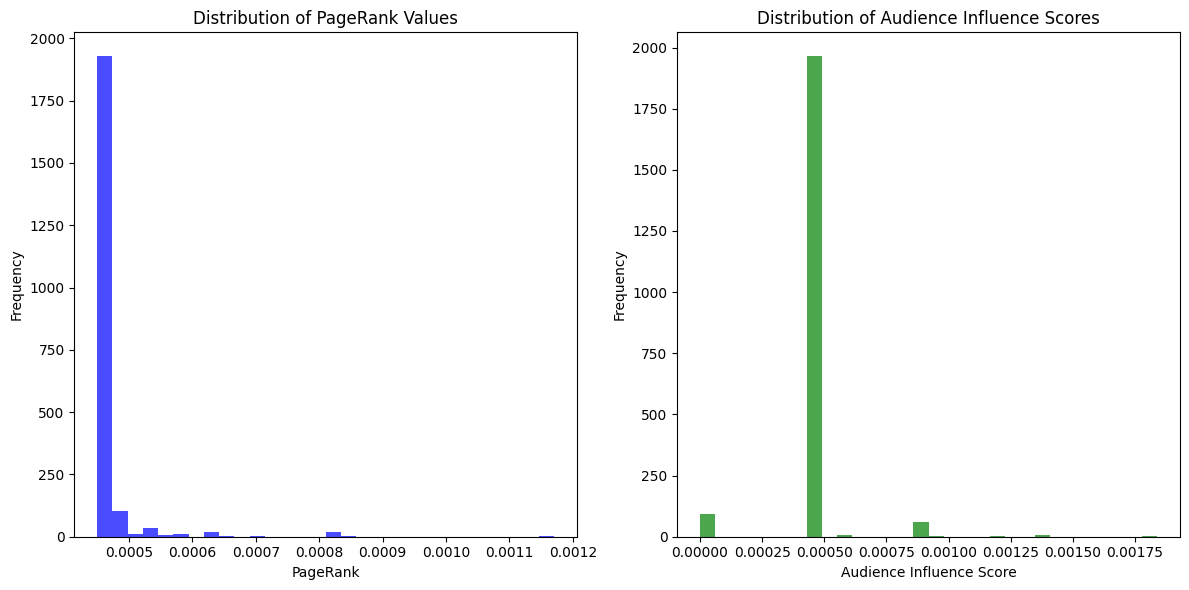

({1603914020783722496: 0.001170875173396663,
  1658052537700974593: 0.0008489573209907519,
  1161005968974467072: 0.0008324676792514638,
  1608119281497276418: 0.0008324676792514638,
  1372122527565107203: 0.0008324676792514638,
  1462674799952494598: 0.0008324676792514638,
  192391896: 0.0008324676792514638,
  1551181248017879041: 0.0008324676792514638,
  1433015197229191168: 0.0008324676792514638,
  1702976965396074496: 0.0008324676792514638,
  1014835418733297664: 0.0008324676792514638,
  1623979120941211648: 0.0008324676792514638,
  1719991356511416320: 0.0008324676792514638,
  1135218253003776001: 0.0008324676792514638,
  1335910188633616384: 0.0008324676792514638,
  885830845700780033: 0.0008324676792514638,
  1551753456993480704: 0.0008324676792514638,
  2647333260: 0.0008324676792514638,
  2923593805: 0.0008324676792514638,
  1602352729275383808: 0.0008324676792514638,
  1720086083936124929: 0.0008324676792514638,
  1395734789366292480: 0.0006977309304804744,
  1705056144631504

In [84]:
node = sat
# 그래프 생성
G = nx.from_pandas_edgelist(node, 'source', 'target',create_using=nx.DiGraph)
pr = nx.pagerank(G,alpha=0.85)
print(pr)

# 노드 리스트 추출
nodes = list(G.nodes())

# 노드 개수를 기반으로 빈 행렬 생성
adj_matrix = np.zeros((len(nodes), len(nodes)))

# 각 엣지에 대한 인접 행렬 정보 채우기
for edge in G.edges():
    source_idx = nodes.index(edge[0])
    target_idx = nodes.index(edge[1])
    adj_matrix[source_idx][target_idx] = 1

network_metrics = analyze_network(G)
print(network_metrics)
analyze_and_plot_network(G)

{1632412963025076224: 0.00491524617122119, 1212749115878100992: 0.008080226895012222, 1685840285987946496: 0.006133763749880738, 1394605528391716867: 0.006133763749880738, 1707722801329913856: 0.010624871396940213, 798147039775236097: 0.006655985569306258, 1688162157069029378: 0.005890060234148828, 1641435795956568072: 0.00491524617122119, 1713550551357796352: 0.005817265677501635, 1704427887548616705: 0.006273022901727543, 1723300721364484096: 0.006481911629497751, 1714656639293489152: 0.009615242546050874, 1709010404394016768: 0.005715986294340321, 939433351: 0.00491524617122119, 553198093: 0.00491524617122119, 1101395108551782400: 0.009928575637706185, 1641822145465708551: 0.00491524617122119, 1705901747225735168: 0.009472818413480277, 1601961610095915009: 0.00491524617122119, 1424727083767394309: 0.010137464365476394, 1728446330794819584: 0.006238208113765842, 1716361814739705856: 0.00491524617122119, 1453320646243487751: 0.00491524617122119, 1321729608807452672: 0.0111819080043274

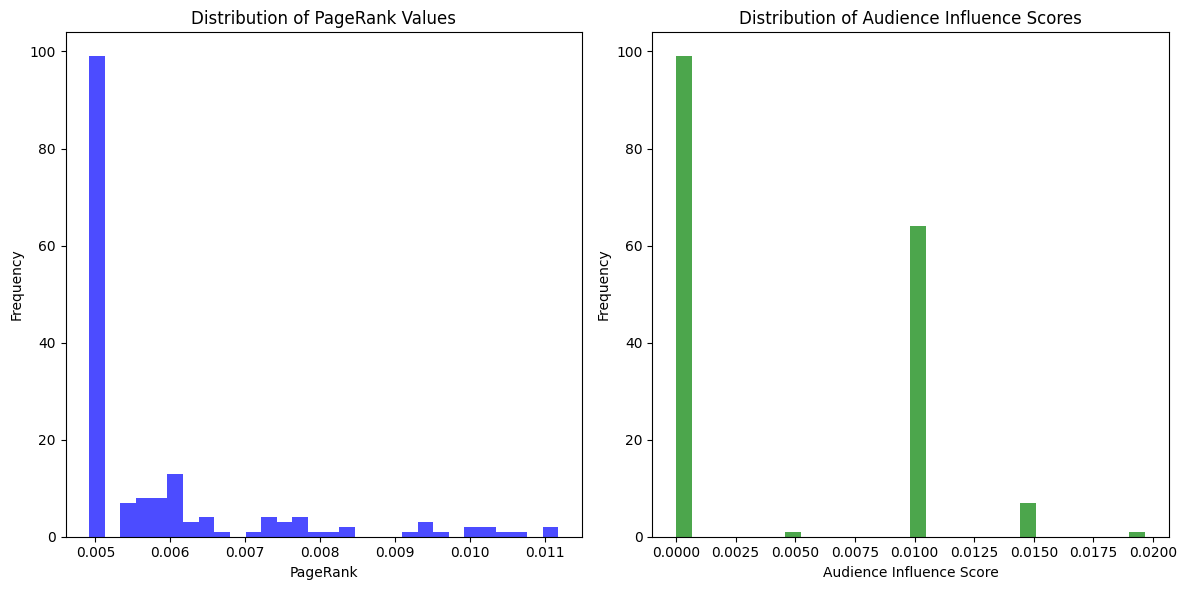

({1321729608807452672: 0.011181908004327435,
  1470419575959605248: 0.011181908004327435,
  1707722801329913856: 0.010624871396940213,
  1383352559549648902: 0.010485612245093407,
  1658052537700974593: 0.01030837332456111,
  1424727083767394309: 0.010137464365476394,
  1101395108551782400: 0.009928575637706185,
  1619371392528703488: 0.009928575637706185,
  1714656639293489152: 0.009615242546050874,
  1705901747225735168: 0.009472818413480277,
  1728796426342465536: 0.009414388000117981,
  1705148343239008256: 0.009371539030318964,
  1437792011730538504: 0.009093020726625354,
  1392492040903008256: 0.008396724967391326,
  1020283766290333699: 0.008396724967391326,
  1212749115878100992: 0.008080226895012222,
  1584063874600677376: 0.007839688360004104,
  1463411055753715716: 0.007763172342505859,
  1266940941635485699: 0.007700429208157298,
  1655268363478913027: 0.007700429208157298,
  1469949691869941762: 0.007700429208157298,
  1299756880114233344: 0.007623913190659053,
  172562794

In [126]:
node = sat
# 그래프 생성
G = nx.from_pandas_edgelist(node, 'source', 'target',create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))
G_preprocessed = remove_low_interaction_nodes(G)
pr = nx.pagerank(G_preprocessed,alpha=0.85)
print(pr)


# 노드 리스트 추출
nodes = list(G_preprocessed.nodes())

# 노드 개수를 기반으로 빈 행렬 생성
adj_matrix = np.zeros((len(nodes), len(nodes)))

# 각 엣지에 대한 인접 행렬 정보 채우기
for edge in G_preprocessed.edges():
    source_idx = nodes.index(edge[0])
    target_idx = nodes.index(edge[1])
    adj_matrix[source_idx][target_idx] = 1

network_metrics = analyze_network(G_preprocessed)
print(network_metrics)
analyze_and_plot_network(G_preprocessed)

In [127]:
G = nx.from_pandas_edgelist(node, 'source', 'target',create_using=nx.DiGraph)
original_metrics, preprocessed_metrics, changerate = compare_networks(G, G_preprocessed)
print(original_metrics)
print(preprocessed_metrics)
print(changerate)

{'number_of_nodes': 2135, 'number_of_edges': 2124, 'density': 0.0004661892104853065, 'average_clustering': 0.0, 'average_shortest_path_length': None}
{'number_of_nodes': 172, 'number_of_edges': 154, 'density': 0.005235958112335101, 'average_clustering': 0.0, 'average_shortest_path_length': None}
{'number_of_nodes': 0.08056206088992975, 'number_of_edges': 0.07250470809792843, 'density': 11.231401316397754, 'average_clustering': None, 'average_shortest_path_length': None}


## gexf 추출

In [110]:
node = science

G = nx.from_pandas_edgelist(node, 'Key', 'Value', create_using=nx.DiGraph)

# Remove self-loops from the graph 
nx.selfloop_edges(G)
G.remove_edges_from(nx.selfloop_edges(G))
G = remove_low_interaction_nodes(G)

page_ranks = nx.pagerank(G, alpha=0.85)
audience_influence = {}
for node in G.nodes():
    in_edges = G.in_edges(node)
    audience_influence[node] = sum(page_ranks[source] for source, _ in in_edges)

# Add PageRank and audience influence as attributes to each node
for node in G.nodes():
    G.nodes[node]['pagerank'] = page_ranks[node]
    G.nodes[node]['audience_influence'] = float(audience_influence[node])  # Convert to float

# Export the network to a GEXF file
nx.write_gexf(G, "network_science.gexf")

In [91]:
node = gender
G = nx.from_pandas_edgelist(node, 'source' , 'target',create_using=nx.DiGraph)
G = remove_low_interaction_nodes(G)

page_ranks = nx.pagerank(G, alpha=0.85)
audience_influence = {}
for node in G.nodes():
    in_edges = G.in_edges(node)
    audience_influence[node] = sum(page_ranks[source] for source, _ in in_edges)

# Add PageRank and audience influence as attributes to each node
for node in G.nodes():
    G.nodes[node]['pagerank'] = page_ranks[node]
    G.nodes[node]['audience_influence'] = audience_influence[node]

# Export the network to a GEXF file
nx.write_gexf(G, "network_gender.gexf")

In [112]:
node = sat
G = nx.from_pandas_edgelist(node, 'source' , 'target',create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))
G_preprocessed = remove_low_interaction_nodes(G)

page_ranks = nx.pagerank(G, alpha=0.85)
audience_influence = {}
for node in G.nodes():
    in_edges = G.in_edges(node)
    audience_influence[node] = sum(page_ranks[source] for source, _ in in_edges)

# Add PageRank and audience influence as attributes to each node
for node in G.nodes():
    G.nodes[node]['pagerank'] = page_ranks[node]
    G.nodes[node]['audience_influence'] = float(audience_influence[node])  # Convert to float

# Export the network to a GEXF file
nx.write_gexf(G, "network_sat.gexf")

In [102]:
node = queer
G = nx.from_pandas_edgelist(node, 'source' , 'target',create_using=nx.DiGraph)
G = remove_low_interaction_nodes(G)

page_ranks = nx.pagerank(G, alpha=0.85)
audience_influence = {}
for node in G.nodes():
    in_edges = G.in_edges(node)
    audience_influence[node] = sum(page_ranks[source] for source, _ in in_edges)
    

# Add PageRank and audience influence as attributes to each node
for node in G.nodes():
    G.nodes[node]['pagerank'] = page_ranks[node]
    G.nodes[node]['audience_influence'] = float(audience_influence[node])  # Convert to float

# Export the network to a GEXF file
nx.write_gexf(G, "network_queer.gexf")